Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

  

Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя
age – возраст
attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 
просмотры
лайки
​
 ∗1000)
coins – число монеток (внутренняя валюта)
country – страна  
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
gender – пол
age_filter_start  – фильтр поиска, мин. значение 
age_filter_end  – фильтр поиска, макс. значение 
views_count – число полученных оценок 
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
is_premium –  является ли премиум
total_revenue – нормированная выручка
 
transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя
country – страна
joined_at – дата и время регистрации
paid_at – дата и время покупки
revenue – нормированная выручка
payment_id – идентификатор платежа
from_page – откуда пользователь перешел на страницу оплаты
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pingouin as pg
from scipy import stats
from statsmodels. stats.weightstats import ztest as ztest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm.auto import tqdm

plt.style.use('ggplot')

C:\Users\NXY2\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Укажем общие надстройки для графиков
sns.set(
    font_scale = 2,
    style      = "whitegrid",
    rc         = {'figure.figsize':(25,10)}
)

In [3]:
# 1.Для того что бы принимать решение, изучим наши данные, первоначально вгрузив их 


In [4]:
test=pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_users_test.csv',sep=';')# Cчитаем тестовую группу 
test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
test.info() # Посмотрим информацию 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


1. В тестовой группе  4308 наблюдений
2. Премиум был у 408 
3. Премиум есть сейчас у 157
4. Посмотрим зачем нам даны транзакции? Ведь total_revenue у нас дан...

In [6]:
test_transactions = pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_transactions_test.csv',sep=';')# Cчитаем транзакции 
                                                                                                 # тестовой группы 
test_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [7]:
test_transactions.dtypes # Посмотрим на тип данных...

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

Сравним суммарные  total_revenue и revenue, по закону жанра - они должны быть равны
так как revenue подтягивается из test_transactions в  test.revenue

In [8]:
test_transactions.revenue.sum() - test.total_revenue.sum()# В данном лучший вариант , посмотреть разницу 
                                                          # Если отличается от 0 , значит данные подгружаются не верно! 

44083

In [9]:
# Возьмем колонку revenue(групировав по uid) из транзакций для верной выгрузки 
test = test.merge(test_transactions.groupby('uid',as_index=False)['revenue'].sum(), on='uid',how = 'left')
test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaN
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,NaN
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,NaN


In [10]:
test_work = test[['uid','revenue']] # На данном этапе нам нужен небольшой DF, Этого достаточно! 
test_work = test_work.fillna(0)

 Проделаем идентичные манипуляции с остальными данными , так как у нас нет увереннности что и там все выгружается верно ! 

In [11]:
control_1 = pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_users_control_1.csv',sep=';')# Cчитаем контрольну группу 1
control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [12]:
control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


1. В контрольной 1  группе 4340 наблюдений
2. Премиум был у 436
3. Премиум есть сейчас у 192
4. Проверим транзакции? Ведь total_revenue у нас дан...

In [13]:
control_1_transactions = pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_transactions_control_1.csv',sep=';')
control_1_transactions.head()# Данные считаны непрвильно ... исправим это 

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [14]:
control_1_transactions = control_1_transactions.dropna() # Избавимся от Нанов 
control_1_transactions[['uid','revenue','payment_id']] = control_1_transactions[['uid','revenue','payment_id']]\
                                                         .apply(lambda x: x.astype('int64'))
control_1_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727,147,trial_vip_popup,trial_premium
1,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,trial_vip_popup,trial_premium
2,891822480,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911,19,none,coins
3,891367521,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456,127,sympathy,other_type
4,892207959,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261,19,empty_likes,coins


In [15]:
control_1_transactions.revenue.sum() - control_1.total_revenue.sum()# В данном лучший вариант , посмотреть разницу 
                                                          # Если отличается от 0 , значит данные подгружаются не верно! 

31044

In [16]:
# Возьмем колонку revenue(групировав по uid) из транзакций для верной выгрузки 
control_1 = control_1.merge(control_1_transactions.groupby('uid',as_index=False)['revenue'].sum(), on='uid',how = 'left')
control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,NaN
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,NaN
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0,NaN
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0,NaN
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0,NaN


In [17]:
control_1_work = control_1[['uid','revenue']]#  На данном этапе нам нужен небольшой DF, Этого достаточно! 
control_1_work = control_1_work.fillna(0)

In [18]:
control_2 = pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_users_control_2.csv',sep=';')# Считаем данные для контроля 2
control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [19]:
control_2.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


1. В контрольной 2  группе 4264 наблюдений
2. Премиум был у 411
3. Премиум есть сейчас у 191
4. Проверим транзакции? Ведь total_revenue у нас дан...

In [20]:
control_2_transactions =pd.read_csv('C:/Users/NXY2/Downloads/Проект_3_transactions_control_2.csv',sep=';')
control_2_transactions.head()# Посмотрим данные...пока что критических моментов не видно..

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [21]:
control_2_transactions.revenue.sum() - control_2.total_revenue.sum()# В данном лучший вариант , посмотреть разницу 
                                                          # Если отличается от 0 , значит данные подгружаются не верно! 

0

Все корректно, тут нет нужды проводить манипуляции, для удобства и возможных ошибок выгрузок все же обьеденим ДФ, 
как и в предыдущих случаях! 

In [22]:
# Возьмем колонку revenue(групировав по uid) из транзакций для верной выгрузки 
control_2 = control_2.merge(control_2_transactions.groupby('uid',as_index=False)['revenue'].sum(), on='uid',how = 'left')
control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,NaN
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0,NaN
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0,NaN
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0,NaN
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0,NaN


In [23]:
control_2_work = control_2[['uid','revenue']]#  На данном этапе нам нужен небольшой DF, Этого достаточно! 
control_2_work = control_2_work.fillna(0)

Пояснение и план действий:
1.Первоначальна работа по приведению к номальному виду тестовой и двух контролных груп сделана!

- Перед нами класический А/А/В тест 
- Наши выборки разбиты на три части = немного не равномерно - но разница между ними не большая
- Группа control_1_work дана для проведения А/В теста,где В это test_work
- Группа control_2_work  служит для контроля что в наш эксперемент никто не вмешивается! 
  и все идет без сбоев, то есть класический А/А тест с control_1_work
- Попробуем понять с какой статистикой работать...

2.Доработаем еще немного наши данные:  создадим дополнительные колонки с 0 и 1 ( в дальнейшем для расчета
  конверсии) 

In [24]:
test_work['purchase'] = test_work.revenue.apply(lambda x: 0 if x==0 else 1)# 0 - нет покупки, 1 -есть 
test_work.head()

,uid,revenue,purchase
0,892309896,0.0,0
1,892044516,0.0,0
2,892185708,0.0,0
3,892130292,0.0,0
4,891406035,0.0,0


In [25]:
test_work['experVariant'] = 'test'

In [26]:
control_1_work['purchase'] = control_1_work.revenue.apply(lambda x: 0 if x==0 else 1)# 0 - нет покупки, 1 -есть 
control_1_work.head()

,uid,revenue,purchase
0,892319115,0.0,0
1,891248523,0.0,0
2,891670932,0.0,0
3,891060786,0.0,0
4,892006554,0.0,0


In [27]:
control_1_work['experVariant'] = 'control_1' # для дальнейшей удоббной работы в одном ДФ


In [28]:
control_2_work['purchase'] = control_2_work.revenue.apply(lambda x: 0 if x==0 else 1)# 0 - нет покупки, 1 -есть 
control_2_work.head()

,uid,revenue,purchase
0,892035504,0.0,0
1,891782112,0.0,0
2,891110337,0.0,0
3,891796320,0.0,0
4,891880212,0.0,0


In [29]:
control_2_work['experVariant'] = 'control_2'# для дальнейшей удоббной работы в одном ДФ

In [30]:
df = pd.concat([test_work,control_1_work,control_2_work],ignore_index=True)
df.head()

,uid,revenue,purchase,experVariant
0,892309896,0.0,0,test
1,892044516,0.0,0,test
2,892185708,0.0,0,test
3,892130292,0.0,0,test
4,891406035,0.0,0,test


Данные готовы , посмотрим так с какими же данными и какими тестами м проведем тестирование...
Изначально нужно провести А/А тест, проверим есть ли возможность использовать класические методы среднего!

Проведем проверку сплитования на CR
CR = Это наша конверсия по группе, исчисляется как среднее от набора данных  0,1 
Проведем бутсрапирование для нахождения FPR: 
- если  FPR < Alfa 0.05, наши группы не отличаются.Иными словами сиситема сплитования работает правильно.
- если  FPR > Alfa 0.05  значит есть различия, нужно искать где возникла ошибка.


In [31]:
# Посмотрим на средние CR  
df[df.experVariant!='test'].groupby('experVariant',as_index=False)['purchase'].mean().rename(columns={'purchase':'CR'})
            

,experVariant,CR
0,control_1,0.044470
1,control_2,0.043856


In [32]:
# На глаз не видно разницы, убедимся в этом проведя Бутсрап без возврата: 


  0%|          | 0/1000 [00:00<?, ?it/s]

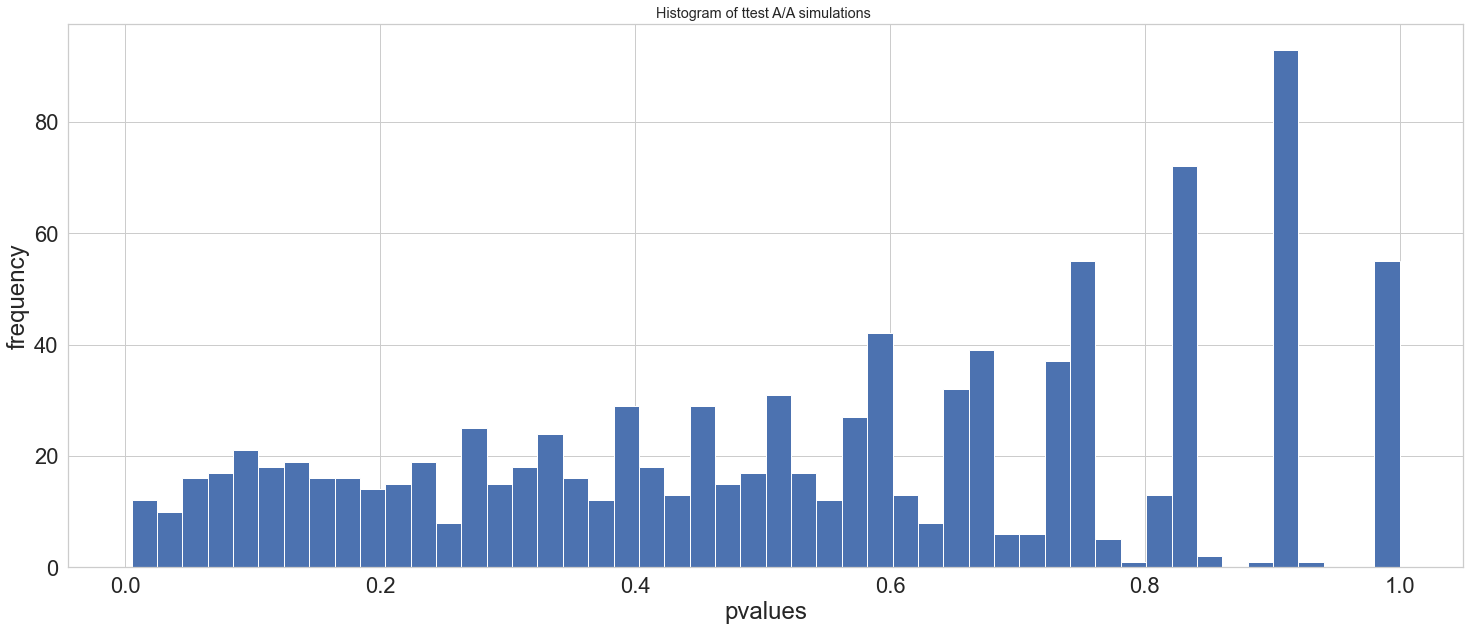

0.028

In [33]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experVariant=='control_1'].purchase.sample(n_s, replace = False).values
    s2 = df[df.experVariant=='control_2'].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Наш FPR cоставляет 0,022 что занчительно меньше порогового значения  Альфа 0,05.
Другими словами - мы не нашли значимых 
различий в CR двух групп, значит пока что нет вмешательства в эксперемент ! 

1. Что делаем дальше? 
2. На какие статистики(метрики)  обращаем внимание ? 
3. Какой тест будем использовать для проведения А/В тестирования? Какие критерии для его проведения? 
4. Какие допущения в тестах ( нулевая / альтернативная гипотеза) 

КАКИЕ МЕТРИКИ БУДЕМ ИСПОЛЬЗОВАТЬ?ЧТО ВАЖНО ДЛЯ БИЗНЕСА? 

1.ARPU это сумма всех пользователей / кол-во уникальных пользователей

2.ARPPU сумма всех платящих пользователей / кол-во уникальных платящих пользователей

3.CR  - уже известная нам величина, конверсия в покупку 



In [34]:
# 1. Посмотрим на  ARPU и CR всех трех групп:
df_CR_ARPU_ARPPU = df.groupby('experVariant',as_index=False)\
               .agg({'purchase':'mean','revenue':'mean'})\
               .rename(columns={'purchase':'CR','revenue':'ARPU'})   
df_CR_ARPU_ARPPU

,experVariant,CR,ARPU
0,control_1,0.044470,601.914977
1,control_2,0.043856,450.384146
2,test,0.033890,544.313138


In [35]:
#Посмотрим на  ARPPU в трех групп:
df_ARPPU = df[df.revenue!=0].groupby('experVariant',as_index=False)\
                            .agg({'revenue':'mean'})\
                            .rename(columns={'revenue':'ARPPU'})  
df_ARPPU

,experVariant,ARPPU
0,control_1,13535.290155
1,control_2,10269.721925
2,test,16060.965753


In [36]:
# одьеденим для удобства статистики 
df_CR_ARPU_ARPPU ['ARPPU'] = df_ARPPU['ARPPU']
df_CR_ARPU_ARPPU 

,experVariant,CR,ARPU,ARPPU
0,control_1,0.044470,601.914977,13535.290155
1,control_2,0.043856,450.384146,10269.721925
2,test,0.033890,544.313138,16060.965753


Как видим результаты на 'глаз' отличаются и довольно значительно:
Конверсия в тесте оказалось намного ниже чем в контролях.
ARPU - довольно близко к контролям.
ARRPU значительно  выше в тесте. 
Для принятия решения нужно проводить А/В тест  в два этапа 
- сравнивая с контрольной группой 1 
- сравнивая с контрольной группой 2 


Но перед этим попробуем визуализировать данные и провести тест Шапиро Вилка - для понимания, 
каким А/В тестом мы будем пользоваться.


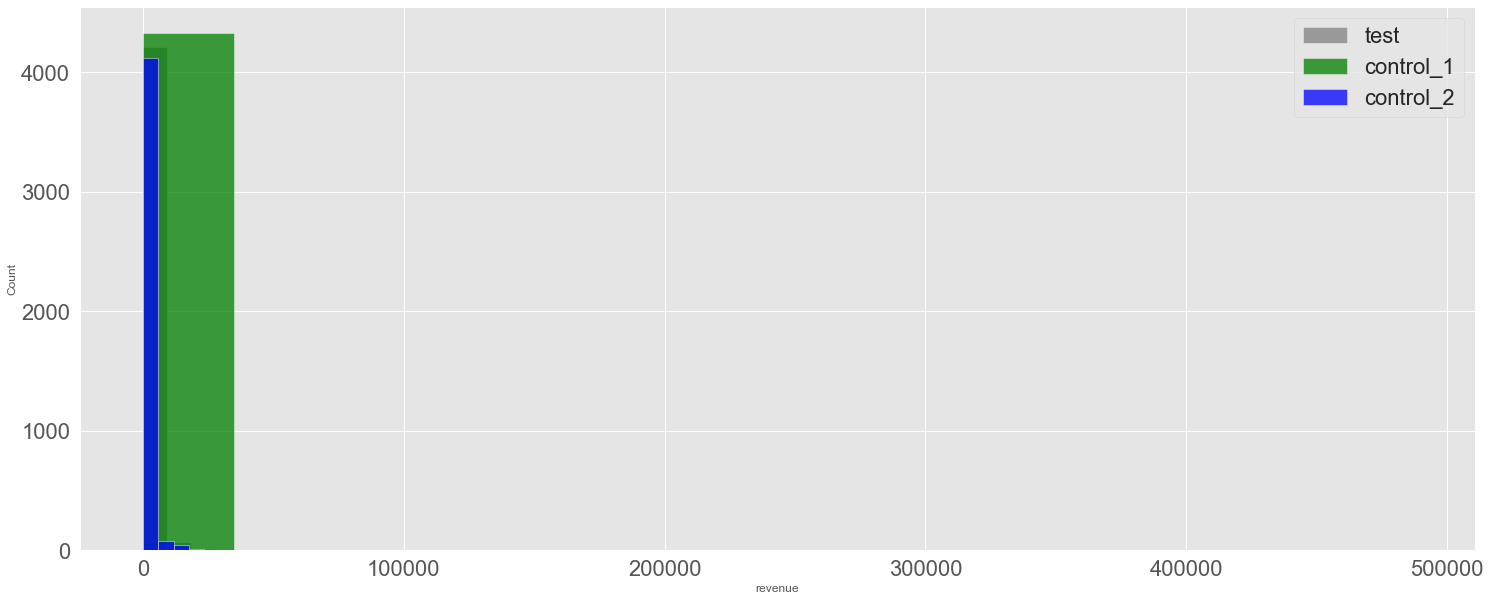

In [37]:
# для ARPU 
sns.histplot(df[df.experVariant=='test'].revenue,kde=False,label='test',color='Grey');
sns.histplot(df[df.experVariant=='control_1'].revenue,kde=False,label='control_1',color='Green');
sns.histplot(df[df.experVariant=='control_2'].revenue,kde=False,label='control_2',color='Blue');
plt.legend(['test','control_1','control_2'])
plt.show()

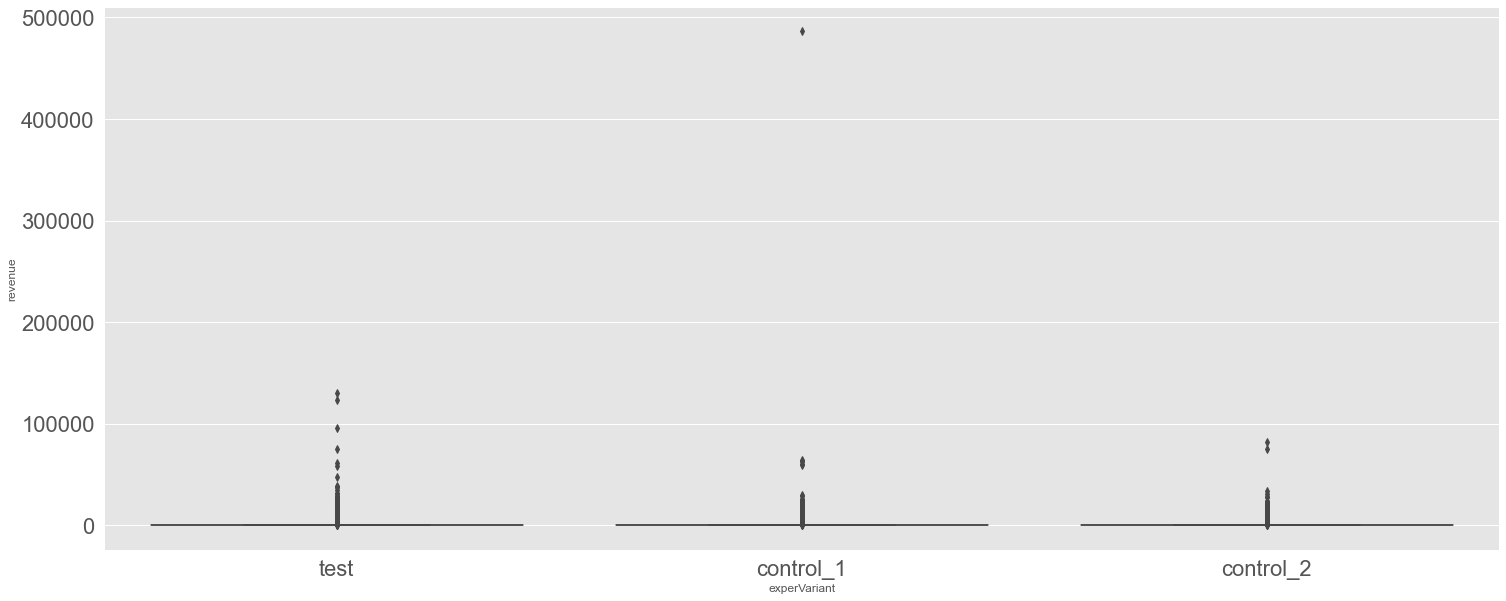

In [38]:
# Посмотрим на выбросы ARPU :
sns.boxplot(x ='experVariant',y='revenue' ,data=df);

Проведем тест Шапиро Вилка для ARPU 

In [39]:
test_sample = df[df.experVariant=='test'].revenue.sample(n=1000 ,random_state=17)
control_1_sample = df[df.experVariant=='control_1'].revenue.sample(n=1000 ,random_state=17)
control_2_sample = df[df.experVariant=='control_2'].revenue.sample(n=1000 ,random_state=17)
print(stats.shapiro(test_sample),
stats.shapiro(control_1_sample),
stats.shapiro(control_2_sample))

ShapiroResult(statistic=0.09746277332305908, pvalue=0.0) ShapiroResult(statistic=0.1562764048576355, pvalue=0.0) ShapiroResult(statistic=0.1734728217124939, pvalue=0.0)


Проверим наши данные на гомоскедастичность, используя пингвин:

In [40]:
pg.homoscedasticity(data=df, dv='revenue', group='experVariant')

,W,pval,equal_var
levene,0.81494,0.442689,True


Как мы видим для ARPU :
1. Есть значительные выбросы
2. Наши выборки распределены не нормально - исходя из предположения о тесте Шапиро Вилка,
   нам нужно принимать нулевую гипотезу H0 : P-value >0.05 ) 
3. Данные гомоскедастичны, после проведения теста, P-value>0.05(0.44) 
4. Для t-testa нужны гомогенность дисперсий + нормальность распределения ГС

Гомоскедастичность у нас есть, а вот о нормальности распределения этого сказать нельзя.
Но в принципе для t-testa главное большое кол-во данных , и предположение нормальности распределения ГС. Так что этот тест 
мы можем использовать для проверки ARPU, но вот выбросы могут очень сильно помешать выводам! 
Мани Витни ? 
- Мани Витни подойдет так как он устойчив к выбросам.
- Основной минус - мы не получаем интерпретируемой статистики.

Бутсрап ? 
- можем проверить любую статистику, довольно интерпретируем 
- Довольно медленно работает на больших данных 
- А у нас не так уж и много ( относительно) данных 

Будем использовать Бутсрап !!! 

H0 - ARPU не отличаются 
H1 - есть значительные отличия 
Альфа = 0,05 
Проведем  А/В тест с первой контрольной группой:

In [41]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

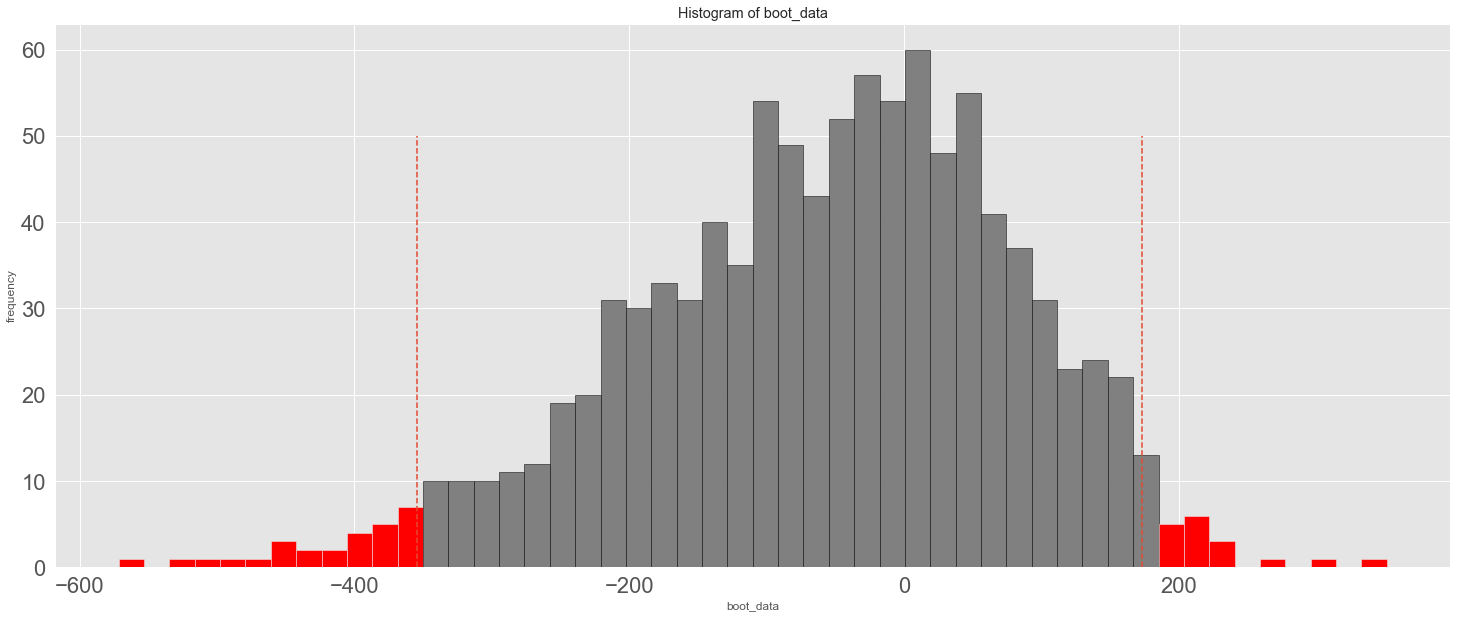

In [42]:
#Построим Будстрап ARPU для первой контрольной группы, с ДИ и p_value:
booted_data_ARPU_1 = get_bootstrap(df[df.experVariant=='test'].revenue, df[df.experVariant=='control_1'].revenue)

In [43]:
booted_data_ARPU_1["p_value"]

0.6786054713202937

  0%|          | 0/1000 [00:00<?, ?it/s]

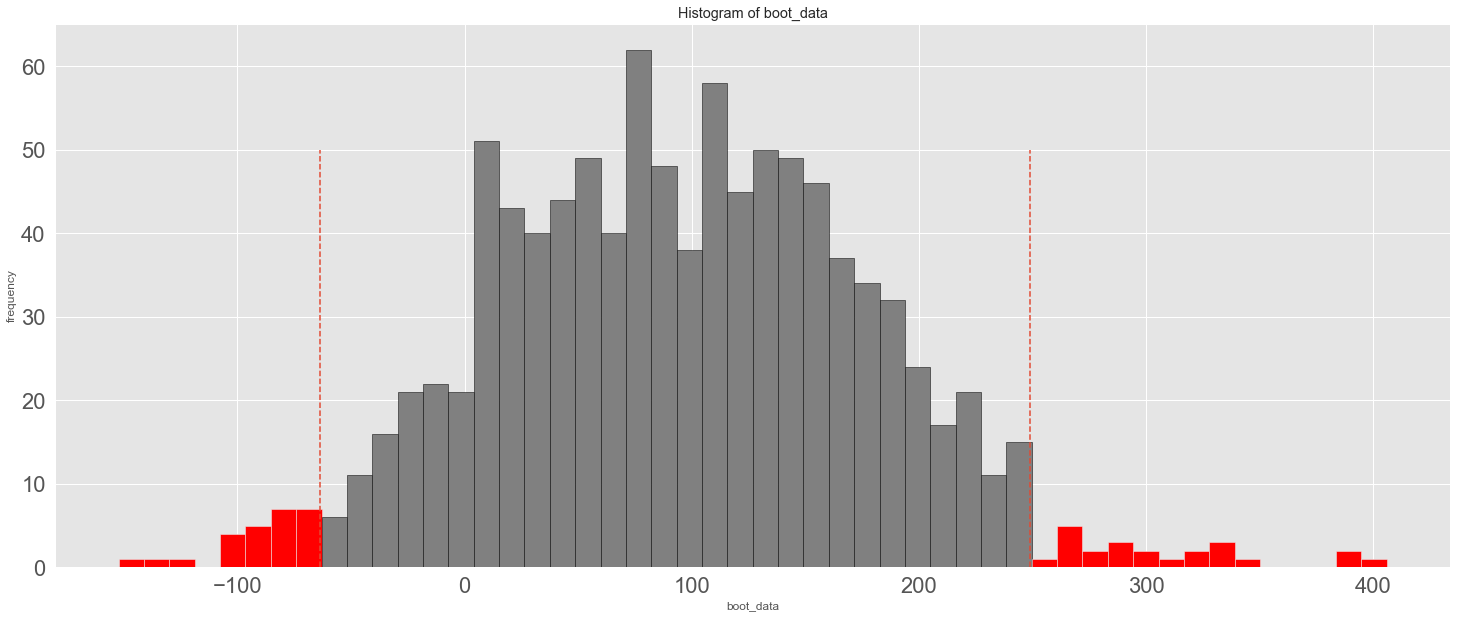

In [44]:
#Построим Будстрап ARPU для второй контрольной группы, с ДИ и p_value:
booted_data_ARPU_2 = get_bootstrap(df[df.experVariant=='test'].revenue, df[df.experVariant=='control_2'].revenue)

In [45]:
booted_data_ARPU_2["p_value"]

0.2493883784190435

p_value для Первой контрольной группы == 0,67 
p_value для Первой контрольной группы == 0,24

Что значительно больше нашего порогового значения 0,05 
Значит мы не можем отклонть Нулевую гипотезу о равенстве ARPU в тесте  и контрольных группах! 
Простыми словами - для ARPU А/Б тестирование  не оказалось значимым! 

Посмотрим на ARPPU, посмотрим какой тест подходит исходя их графичесого + Шапиро Вилка + Левина на гомоскедастичность:

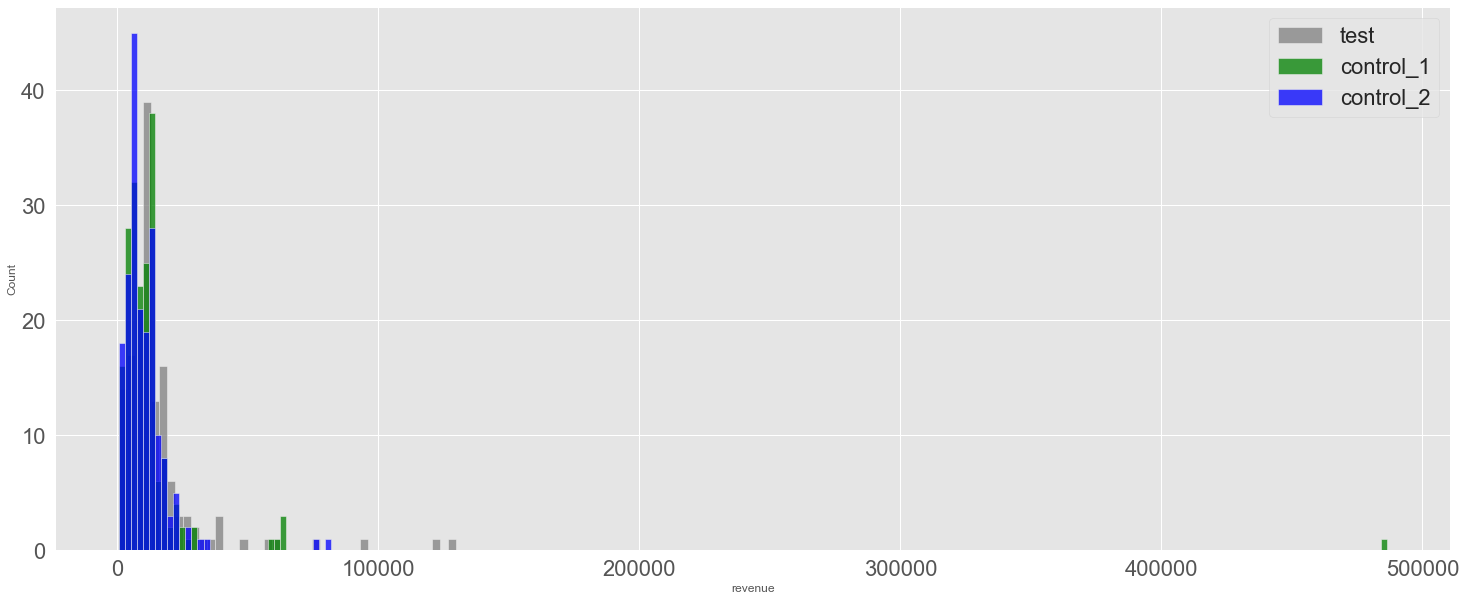

In [46]:
# для ARPPU
sns.histplot(df[df.experVariant=='test'].query('revenue!=0').revenue,kde=False,label='test',color='Grey');
sns.histplot(df[df.experVariant=='control_1'].query('revenue!=0').revenue,kde=False,label='control_1',color='Green');
sns.histplot(df[df.experVariant=='control_2'].query('revenue!=0').revenue,kde=False,label='control_2',color='Blue');
plt.legend(['test','control_1','control_2'])
plt.show()

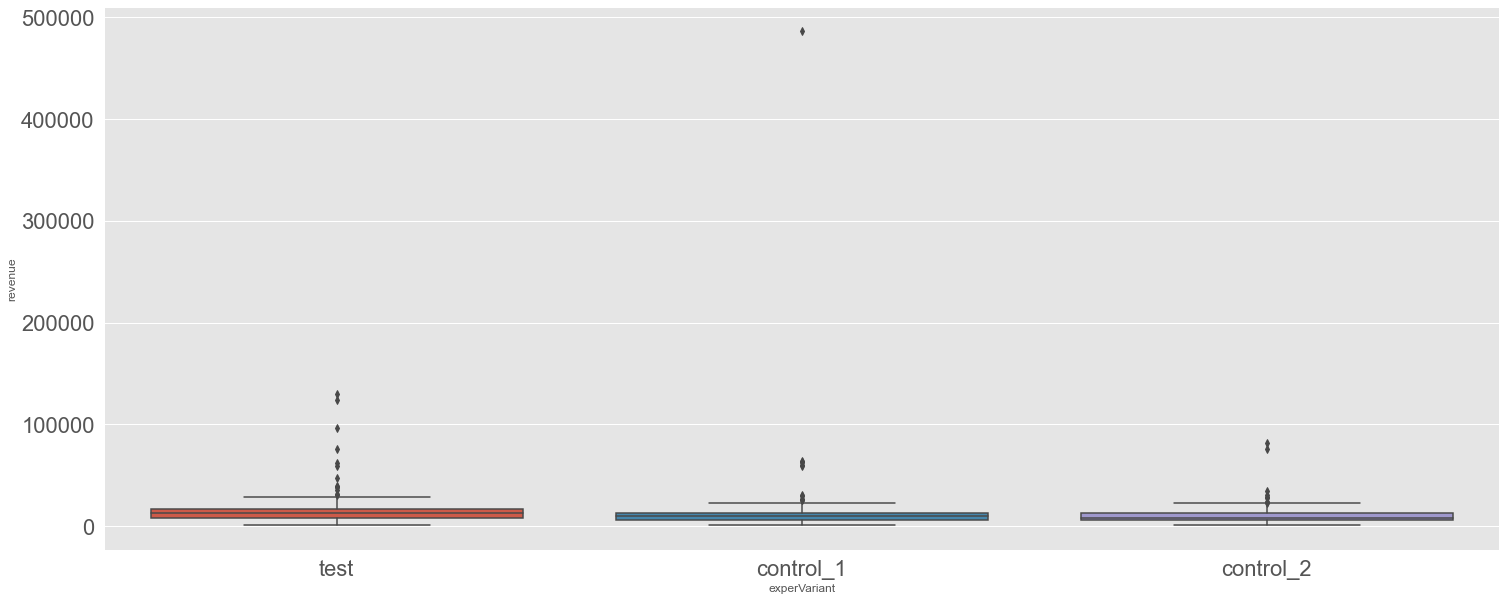

In [47]:
# Посмотрим на выбросы ARPPU :
sns.boxplot(x ='experVariant',y='revenue' ,data=df[df.revenue!=0]);

Проведем тест Шапиро Вилка для ARPPU

In [48]:
test_sample_1 = df[df.experVariant=='test'].query('revenue!=0').revenue.sample(n=100 ,random_state=17)
control_1_sample_1 = df[df.experVariant=='control_1'].query('revenue!=0').revenue.sample(n=100 ,random_state=17)
control_2_sample_1 = df[df.experVariant=='control_2'].query('revenue!=0').revenue.sample(n=100 ,random_state=17)
print(stats.shapiro(test_sample_1),
stats.shapiro(control_1_sample_1),
stats.shapiro(control_2_sample_1))

ShapiroResult(statistic=0.507425844669342, pvalue=1.0166724707656553e-16) ShapiroResult(statistic=0.17258530855178833, pvalue=3.6032431769271706e-21) ShapiroResult(statistic=0.8866422176361084, pvalue=3.504795813569217e-07)


Проверим наши данные на гомоскедастичность, используя пингвин:

In [49]:
pg.homoscedasticity(data=df[df.revenue!=0],dv='revenue',group='experVariant')

,W,pval,equal_var
levene,1.024521,0.359688,True


Как мы видим для ARPPU :
1. Есть значительные выбросы
2. Наши выборки распределены не нормально - исходя из предположения о тесте Шапиро Вилка,
   нам нужно принимать нулевую гипотезу H0 : P-value >0.05 ) 
3. Данные гомоскедастичны, после проведения теста, P-value>0.05(0.35) 
4. Для t-testa нужны гомогенность дисперсий + нормальность распределения ГС

Гомоскедастичность у нас есть, а вот о нормальности распределения этого сказать нельзя.
Но в принципе для t-testa главное большое кол-во данных , и предположение нормальности распределения ГС. Так что этот тест 
мы можем использовать для проверки ARPU, но вот выбросы могут очень сильно помешать выводам! 
Можем ли мы использовать логарифмирование для нивелирования выросов ? 
Попытаемся ! 


In [50]:
# Сделаем логарифмизацию ARPPU, для этого создадим доплнительную колонку revenue_log ^:
df_log = df.query('revenue!=0').reset_index()
log = np.log(df_log['revenue'])
df_log['revenue_log'] = np.log(df_log['revenue'])
df_log.head()

,index,uid,revenue,purchase,experVariant,revenue_log
0,20,891152790,12597.0,1,test,9.441214
1,35,892333656,897.0,1,test,6.799056
2,44,891589239,37817.0,1,test,10.540514
3,100,891343671,21580.0,1,test,9.979522
4,105,892430988,12727.0,1,test,9.451481


<AxesSubplot:xlabel='experVariant', ylabel='revenue_log'>

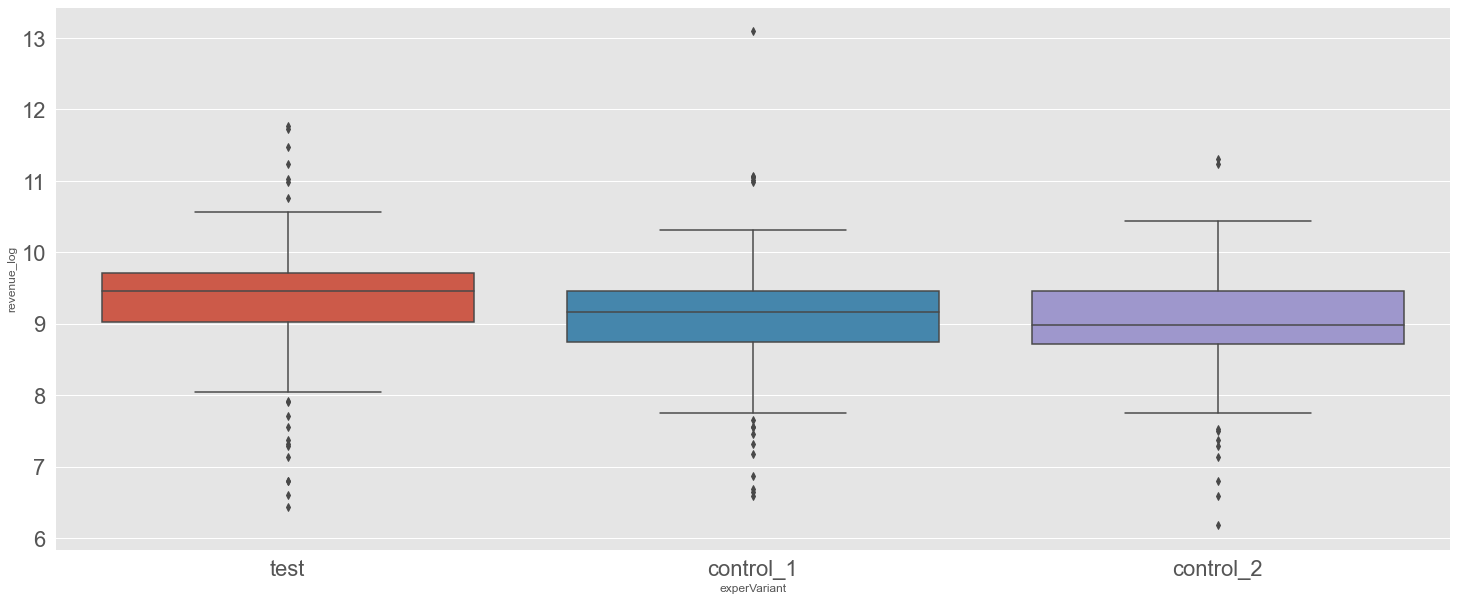

In [51]:
# Построим боксплоты 
sns.boxplot(x ='experVariant',y='revenue_log' ,data=df_log)

Как видим выбросы остались, выбрасывать их нельзя - возможно они свидетельствуют о кактх то ключевых и важных группах!

Мани Витни ? 
- Мани Витни подойдет так как он устойчив к выбросам.
- Основной минус - мы не получаем интерпретируемой статистики.

Бутсрап ? 
- можем проверить любую статистику, довольно интерпретируем 
- Довольно медленно работает на больших данных 
- А у нас не так уж и много ( относительно) данных 

Будем использовать Бутсрап !!! 

H0 - ARРPU не отличаются 
H1 - есть значительные отличия 
Альфа = 0,05 
Проведем  А/В тест

  0%|          | 0/1000 [00:00<?, ?it/s]

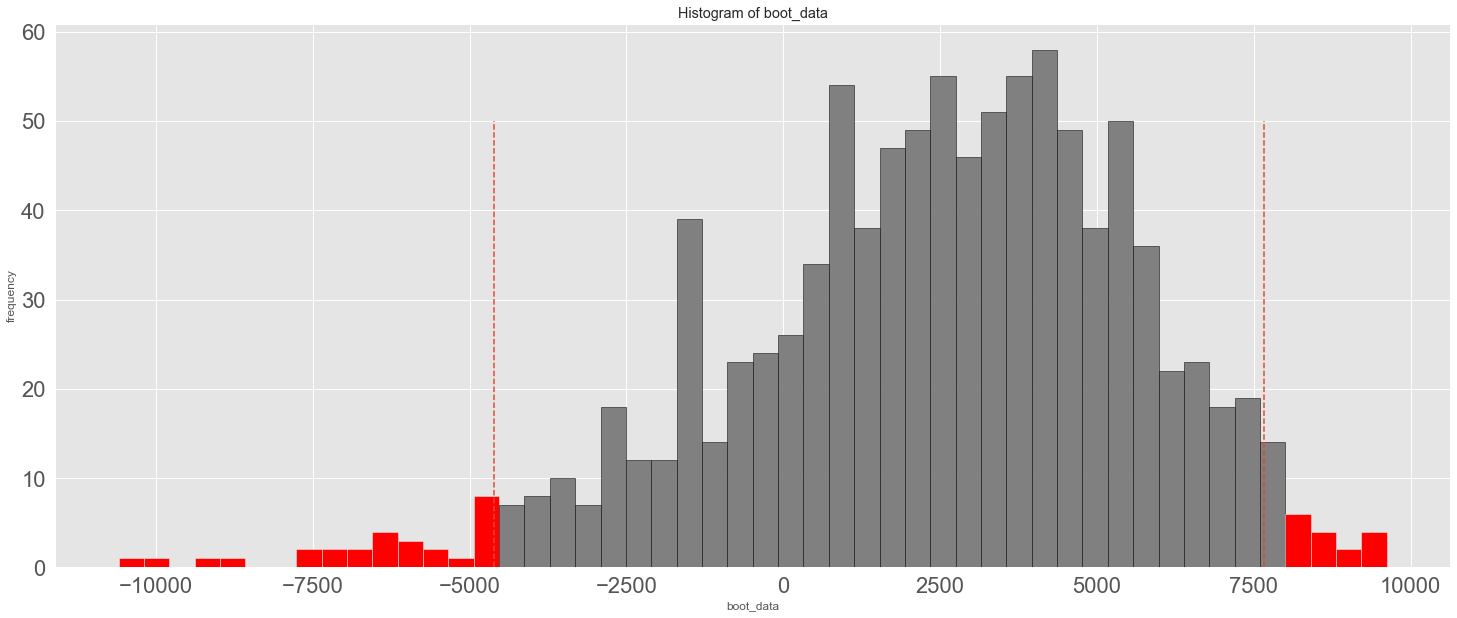

In [52]:
#Построим Будстрап ARPPU для первой контрольной группы, с ДИ и p_value:
booted_data_ARPPU_1 = get_bootstrap(df[df.experVariant=='test'].query('revenue!=0').revenue,\
                                   df[df.experVariant=='control_1'].query('revenue!=0').revenue)

In [53]:
booted_data_ARPPU_1['p_value']

0.4528101674475765

  0%|          | 0/1000 [00:00<?, ?it/s]

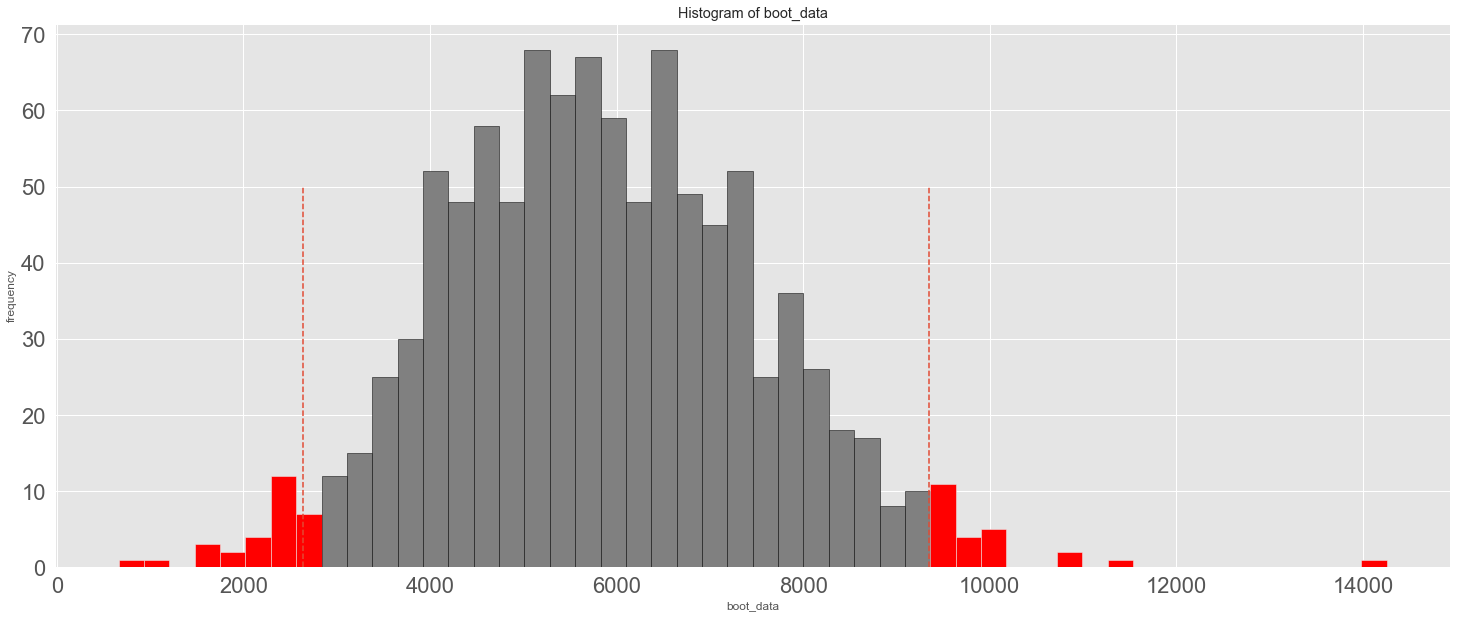

In [54]:
#Построим Будстрап ARPPU для второй контрольной группы, с ДИ и p_value:
booted_data_ARPPU_2 = get_bootstrap(df[df.experVariant=='test'].query('revenue!=0').revenue,\
                                   df[df.experVariant=='control_2'].query('revenue!=0').revenue)

In [55]:
booted_data_ARPPU_2['p_value']

0.0004929134697818449

Вывод для ARPPU:
p_value для Первой контрольной группы == 0,45
p_value для Второй контрольной группы == 0,0004

Для Первой контрольной группы мы не можем отклонить Нулевую гипотезу о равенстве ARPPU!
Для Второй контрольной группы мы отклоняем Нулевую гипотезу , и предполагаем значимые разлчия в ARPPU


- СR
Третья метрика : конверсия , на которой мы проверяли систему сплитования! 
То есть среднее от набора 0,1 по колонке 'purchase' - и есть наша конверсия.
В первом Варианте мы испробовали метод Бутсрапа, но попытаемся задуматься а что такое 0,1 ? 
Ведь это биномиальная группа разделенная в некоторой пропорции , где известно Стандартное оклонени  в ГС
А если известно Стандартное оклонение можно воспользоваться Z - тестом ( двустронним)
И так используем и проверим наши допущения: 

H0 Нет отличий CR группах 
Н1 есть значимые отличия в группах по СR
Альфа 0,05 

In [56]:
# Проверим допущение значимых отличий CR в первой контрольной группе 
ztest(df[df.experVariant=='test'].purchase,df[df.experVariant=='control_1'].purchase)

(-2.535403776503654, 0.011231778070051017)

In [57]:
# Проверим допущение значимых отличий CR во второй  контрольной группе 
ztest(df[df.experVariant=='test'].purchase,df[df.experVariant=='control_2'].purchase)


(-2.3878305189978657, 0.0169481554925751)

p_value 0.011 < 0.05 в первой группе 
p_value 0.016 <0.05 во второй группе

Статистика со знаком '-':
- мы нашли знаимые различия в двух контрольных группах
- различия отрицательные, то есть конверсия у нас ведет в сторону уменьшения! 

Прмежуточный итог по метрикам и эксперементу : 
- В целом только в одной експерементальной группе мы получили положительный результат по ARPPU,
- в контольной группе номер 2 и тесте не смотря на отрицательную конверсию - ARPPU отличается и дает значимые различия.
- CR показывает значимые различия в сторону уменьшения ( отрицательная динамика)

Как показать значимые различия ? по какой метрике ? 
- 1.Посмотрим на наши данные более подробней 
- 2.Посмотрим на групповые отличия 
- 3.Посмотрим на взаимосвязи 
- 4.Метрика ARPPU 
- 5.Mетод - многофакторный дисперсионный анализ 

Для начала поработаем над нашими данными 
 - обьеденим в один рабочий ДФ все данные по ARPPU(revenue)
 - проведем разведку данных 
 - поработаем над группировкой данных на основании разведки 

In [58]:
#Обьеденим наши ДФки 
DF= pd.concat([test,control_1,control_2],ignore_index=True)
DF.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaN
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,NaN
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,NaN


In [59]:
# Обозначим тестовую , контролную 1 и контрольную 2 группы
DF_GLOB = DF.merge(df[['uid','experVariant']],on='uid',how='left')
DF_GLOB.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue,experVariant
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,NaN,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,NaN,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,NaN,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,NaN,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,NaN,test


Какие группы нам важны ? Можем ли мы еще сократить наш ДФ в более компактные группы ? 
- age - Важен , но можем использовать не возраст а фильтр , обьеденив age_filter_start + age_filter_end , поменяв формат на стр
- attraction_coeff  - можем разбить на категории
- visit_days - посчитаем кол-во и посмотрим как действовать 
- country	- оставим как есть 
- gender - проверим кол-во мжчин и женщин, если мужчин большинство - не будем использовать 

In [60]:
DF_GLOB.fillna(0,inplace=True) # заменим пропуски на 0 

In [61]:
DF_GLOB[['age_filter_start','age_filter_end']] = DF_GLOB[['age_filter_start','age_filter_end']].astype('str') #заменим тип

In [62]:
DF_GLOB['age_filter'] = DF_GLOB['age_filter_start'] +'-'+ DF_GLOB['age_filter_end']  #обьеденим фильтры в одну группу 

In [63]:
DF_GLOB.visit_days = DF_GLOB.visit_days.str.strip().str.replace(',',' ').str.split().str.len() #подсчет дней 

In [64]:
DF_GLOB.visit_days.fillna(0,inplace=True)

In [65]:
DF_ARPPU = DF_GLOB[DF_GLOB.revenue!=0] #отберем по оплатам значения для ARPPU 

In [66]:
DF_ARPPU.columns

Index(['uid', 'age', 'attraction_coeff', 'coins', 'country', 'visit_days',
       'gender', 'age_filter_start', 'age_filter_end', 'views_count',
       'was_premium', 'is_premium', 'total_revenue', 'revenue', 'experVariant',
       'age_filter'],
      dtype='object')

In [67]:
DF_ARPPU=DF_ARPPU[['uid','age','attraction_coeff','country','age_filter','gender','visit_days','revenue','experVariant']]
DF_ARPPU.head()

,uid,age,attraction_coeff,country,age_filter,gender,visit_days,revenue,experVariant
20,891152790,29,769,Spain,16-32,1,3.0,12597.0,test
35,892333656,50,436,United States of America,47-53,1,4.0,897.0,test
44,891589239,21,303,Italy,18-24,1,9.0,37817.0,test
100,891343671,26,0,France,23-35,1,9.0,21580.0,test
105,892430988,28,181,United States of America,25-31,1,2.0,12727.0,test


In [68]:
DF_ARPPU.groupby('experVariant',as_index=False).agg({'revenue':'mean','attraction_coeff':'mean'\
                                                ,'visit_days':'mean','uid':'count'})\
                                                .rename(columns={'revenue':'ARPPU','attraction_coeff':'c_mean'\
                                                ,'visit_days':'vis_mean','uid':'count'})

,experVariant,ARPPU,c_mean,vis_mean,count
0,control_1,13535.290155,329.321244,9.569948,193
1,control_2,10269.721925,369.951872,9.251337,187
2,test,16060.965753,365.500000,9.068493,146


посмотрим распределение женщин, мужчин 


In [69]:
pd.crosstab(DF_ARPPU.experVariant, DF_ARPPU.gender).T

experVariant,control_1,control_2,test
gender,,,
0,4,7,2
1,189,180,144


Как видим : кол-во женщин довольно мало, и не представляет сколь большого влияния! 

In [70]:
pd.crosstab(DF_ARPPU.experVariant, DF_ARPPU.age).T.head()

experVariant,control_1,control_2,test
age,,,
16,1,3,0
17,1,0,1
18,1,4,1
19,6,5,5
20,9,9,4


-обращеаем внимание что в некоторых группах есть различия и больше покупок 

In [71]:
pd.crosstab(DF_ARPPU.experVariant, DF_ARPPU.country).T.head() # для разных сттран!

experVariant,control_1,control_2,test
country,,,
Argentina,12,10,7
Australia,3,2,1
Austria,0,1,0
Belgium,4,10,4
Canada,9,4,6


In [72]:
DF_ARPPU.groupby('experVariant',as_index=False)[['attraction_coeff','visit_days','age']].describe().T

0            1            2
attraction_coeff count   193.000000   187.000000   146.000000
                 mean    329.321244   369.951872   365.500000
                 std     241.586532   269.191607   233.799037
                 min       0.000000     0.000000     0.000000
                 25%     181.000000   173.500000   199.250000
                 50%     291.000000   318.000000   336.500000
                 75%     454.000000   537.000000   500.000000
                 max    1000.000000  1000.000000  1000.000000
visit_days       count   193.000000   187.000000   146.000000
                 mean      9.569948     9.251337     9.068493
                 std       8.352054     7.899635     8.100794
                 min       0.000000     0.000000     0.000000
                 25%       3.000000     2.000000     2.000000
                 50%       8.000000     7.000000     7.000000
                 75%      15.000000    16.000000    14.000000
                 max      31.000000    28.000000    29.000000
age              count   193.000000   187.000000   146.000000
                 mean     31.683938    31.748663    33.280822
                 std      10.676522    10.585339    10.614722
                 min      16.000000    16.000000    17.000000
                 25%      25.000000    24.000000    25.250000
                 50%      29.000000    29.000000    33.000000
                 75%      37.000000    38.500000    38.000000
                 max      99.000000    99.000000    99.000000

Как мы видим , мы можем создать еще категоральные перменные для attraction_coeff , visit_days 
- Для attraction_coeff : low, medium,high ( разобьем кванитльным методом ) 
- Для visit_days : low,medium, high    (разобьем кванитльным методом)
- Для возвраста разобьем на 4 части : young,middle, senior,elderly 

In [73]:
# Разобьем наши  данные 3 части ( будет 3 категорий : 
quintiles =DF_ARPPU[['attraction_coeff','visit_days']].quantile([.5, .75]).to_dict()
quintiles

{'attraction_coeff': {0.5: 314.5, 0.75: 500.0},
 'visit_days': {0.5: 7.5, 0.75: 15.0}}

In [74]:
#Функция которая пробегает и дает название группам 
def A_score(x):
    if x <= quintiles['attraction_coeff'][.5]:
        return 'low_a'
    elif x <= quintiles['attraction_coeff'][.75]:
        return 'medium_a'
    else:
        return 'high_a'

In [75]:
DF_ARPPU['attraction'] = DF_ARPPU['attraction_coeff'].apply(lambda x: A_score(x))# создадим колонку с новой группой


In [76]:
#Функция которая пробегает и дает название группам 
def V_score(x):
    if x <= quintiles['visit_days'][.5]:
        return 'low'
    elif x <= quintiles['visit_days'][.75]:
        return 'medium'
    else:
        return 'high'

In [77]:
DF_ARPPU['visit'] = DF_ARPPU['visit_days'].apply(lambda x: V_score(x))# создадим колонку с новой группой 

In [78]:
quintiles_age = DF_ARPPU['age'].quantile([0.25,.75, .9]).to_dict()
quintiles_age

{0.25: 25.0, 0.75: 38.0, 0.9: 46.0}

In [79]:
#Функция которая пробегает и дает название группам 
def age_score(x):
    if x <= quintiles_age[.25]:
        return 'yang'
    elif x <= quintiles_age[.75]:
        return 'midle'
    elif x <= quintiles_age[.9]:
        return 'senior'
    else:
        return 'elderly'

In [80]:
DF_ARPPU['age_group'] = DF_ARPPU['age'].apply(lambda x: age_score(x))# создадим колонку с новой группой 

In [81]:
DF_ARPPU.head()

,uid,age,attraction_coeff,country,age_filter,gender,visit_days,revenue,experVariant,attraction,visit,age_group
20,891152790,29,769,Spain,16-32,1,3.0,12597.0,test,high_a,low,midle
35,892333656,50,436,United States of America,47-53,1,4.0,897.0,test,medium_a,low,elderly
44,891589239,21,303,Italy,18-24,1,9.0,37817.0,test,low_a,medium,yang
100,891343671,26,0,France,23-35,1,9.0,21580.0,test,low_a,medium,midle
105,892430988,28,181,United States of America,25-31,1,2.0,12727.0,test,low_a,low,midle


Так как мы изначально выяснили, что группы гомоскедастичны :
Самое время для теста ANOVA 
Хотим увидеть а значимы ли данные группы для нашего анализа: 

In [82]:
# Запустим тест : только с тест и контроль 2 
pg.anova(DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between=['experVariant','visit'])

,Source,SS,DF,MS,F,p-unc,np2
0,experVariant,2.982271e+09,1.0,2.982271e+09,15.660686,0.000093,0.045703
1,visit,2.243724e+09,2.0,1.121862e+09,5.891191,0.003066,0.034779
2,experVariant * visit,6.160711e+08,2.0,3.080356e+08,1.617575,0.199962,0.009797
3,Residual,6.227074e+10,327.0,1.904304e+08,NaN,NaN,NaN


Из теста видно :
- visit
- experrVar 
 p_unc < 0.05 
Это позволяет нам предположить что между тестом и контролем 2 есть 
1. Взаимосвязь 
2. Есть значимые различия в этих группах 
3. В каких именно - сможем проверить попарным тестом 

In [83]:
# Для Сттран выполним те же манипуляции : 
pg.anova(DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between=['experVariant','country'])

C:\Users\NXY2\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 16
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,experVariant,2.291199e+09,1.0,2.291199e+09,11.364094,8.478824e-04,0.036853
1,country,7.611008e+10,20.0,3.805504e+09,18.874881,1.884637e-36,0.559672
2,experVariant * country,1.745854e+09,20.0,8.729271e+07,0.432962,9.851947e-01,0.028330
3,Residual,5.988036e+10,297.0,2.016174e+08,NaN,NaN,NaN


Видим значимые различия  между этими группами исходя из p_unc <0.05
Это позволяет нам предположить что между тестом и контролем 2 есть 
1. Взаимосвязь 
2. Есть значимые различия в этих группах 
3. В каких именно - сможем проверить попарным тестом 

In [84]:
# Для возврастного группы  выполним те же манипуляции : 
pg.anova(DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between=['experVariant','age_group'])

,Source,SS,DF,MS,F,p-unc,np2
0,experVariant,2.692970e+09,1.0,2.692970e+09,13.601091,0.000265,0.040168
1,age_group,3.814414e+08,3.0,1.271471e+08,0.642168,0.588379,0.005893
2,experVariant * age_group,4.001885e+08,3.0,1.333962e+08,0.673729,0.568674,0.006181
3,Residual,6.434891e+10,325.0,1.979966e+08,NaN,NaN,NaN


Видим значимые различия  между этими группами исходя из p_unc > 0.05
Это позволяет нам предположить что между тестом и контролем 2 есть 
Значимых различий не выявлено 
 

In [85]:
# Для Атракшин    выполним те же манипуляции : 
pg.anova(DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between=['experVariant','attraction'])

,Source,SS,DF,MS,F,p-unc,np2
0,experVariant,2.737350e+09,1.0,2.737350e+09,14.054917,0.000210,0.041210
1,attraction,7.729300e+08,2.0,3.864650e+08,1.984304,0.139128,0.011991
2,experVariant * attraction,6.707566e+08,2.0,3.353783e+08,1.721999,0.180325,0.010422
3,Residual,6.368685e+10,327.0,1.947610e+08,NaN,NaN,NaN


Все же, не смотря на данные - проверю попарным тестом атракшин! 

Какие группы проверим ?
- test / control_2
- выявим значимые различия в попарном тесте с группами visit, country , age_group, attraction
- попарный тест тьюки 

In [86]:
#оздадими комбинации для дальнейшего проведения теста 
DF_ARPPU['combination_visit']=DF_ARPPU['experVariant'] + ' \ ' + DF_ARPPU['visit']
DF_ARPPU['combination_visit']

20               test \ low
35               test \ low
44            test \ medium
100           test \ medium
105              test \ low
                ...        
12811      control_2 \ high
12830       control_2 \ low
12838    control_2 \ medium
12881       control_2 \ low
12882    control_2 \ medium
Name: combination_visit, Length: 526, dtype: object

In [87]:
#Запустим тест с visit: 
pg.pairwise_tukey(data=DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between='combination_visit')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control_2 \ high,control_2 \ low,12962.354167,9458.191489,3504.162677,2448.092243,1.431385,0.707853,0.252568
1,control_2 \ high,control_2 \ medium,12962.354167,9092.777778,3869.576389,2863.404807,1.351390,0.755882,0.278094
2,control_2 \ high,test \ high,12962.354167,23656.645161,-10694.290995,3179.656688,-3.363348,0.011047,-0.767395
3,control_2 \ high,test \ low,12962.354167,13262.986486,-300.632320,2557.476124,-0.117550,0.999997,-0.021649
4,control_2 \ high,test \ medium,12962.354167,15367.902439,-2405.548272,2934.611448,-0.819716,0.963778,-0.172812
5,control_2 \ low,control_2 \ medium,9458.191489,9092.777778,365.413712,2501.527995,0.146076,0.999991,0.026335
6,control_2 \ low,test \ high,9458.191489,23656.645161,-14198.453672,2858.106344,-4.967784,0.000016,-1.022613
7,control_2 \ low,test \ low,9458.191489,13262.986486,-3804.794997,2144.583722,-1.774142,0.483953,-0.274469
8,control_2 \ low,test \ medium,9458.191489,15367.902439,-5909.710950,2582.731029,-2.288164,0.201836,-0.425831
9,control_2 \ medium,test \ high,9092.777778,23656.645161,-14563.867384,3220.978630,-4.521566,0.000125,-1.044647


- Выпишем все значения по группам с                                                                  
control_2 \ high	test \ high
control_2 \ low	    test \ high	
control_2 \ medium	test \ high	

Как видим в test Группе visit high - выделяется особым образом! 

In [88]:
#Зададими комбинации для дальнейшего проведения теста  с country:
DF_ARPPU['combination_country']=DF_ARPPU['experVariant'] + ' \ ' + DF_ARPPU['country']
DF_ARPPU['combination_country']

20                               test \ Spain
35            test \ United States of America
44                               test \ Italy
100                             test \ France
105           test \ United States of America
                         ...                 
12811                       control_2 \ Chile
12830                      control_2 \ France
12838                      control_2 \ France
12881    control_2 \ United States of America
12882                    control_2 \ Portugal
Name: combination_country, Length: 526, dtype: object

In [89]:
#Запустим тест с country: 
sumury = pg.pairwise_tukey(data=DF_ARPPU[DF_ARPPU.experVariant!='control_1']\
           ,dv='revenue',between='combination_country').reset_index()
sumury.head() 

,index,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,control_2 \ Argentina,control_2 \ Australia,12101.7,11323.000000,778.700000,10998.655541,0.070800,1.0,0.050623
1,1,control_2 \ Argentina,control_2 \ Austria,12101.7,12168.000000,-66.300000,14892.250002,-0.004452,1.0,-0.004269
2,2,control_2 \ Argentina,control_2 \ Belgium,12101.7,11021.400000,1080.300000,6350.076737,0.170124,1.0,0.072867
3,3,control_2 \ Argentina,control_2 \ Canada,12101.7,7634.250000,4467.450000,8400.361926,0.531816,1.0,0.294544
4,4,control_2 \ Argentina,control_2 \ Chile,12101.7,9874.090909,2227.609091,6204.078446,0.359056,1.0,0.150607


In [90]:
#Проверим есть ли p-tukey< 0.05 
sumury[sumury['p-tukey']<0.05] 

,index,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges


К сожалению , в итоге не смотря на то что Страны это значимый фактор - мы не нашли определенную группу, на которую нужно ориентироваться. 

In [91]:
#Зададими комбинации для дальнейшего проведения теста  с age_group:
DF_ARPPU['combination_age_group']=DF_ARPPU['experVariant'] + ' \ ' + DF_ARPPU['age_group']
DF_ARPPU['combination_age_group']

20              test \ midle
35            test \ elderly
44               test \ yang
100             test \ midle
105             test \ midle
                ...         
12811      control_2 \ midle
12830      control_2 \ midle
12838    control_2 \ elderly
12881      control_2 \ midle
12882      control_2 \ midle
Name: combination_age_group, Length: 526, dtype: object

In [92]:
#Запустим тест с age_grop:
pg.pairwise_tukey(data=DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between='combination_age_group')


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control_2 \ elderly,control_2 \ midle,12304.500000,11347.623529,956.876471,3834.600693,0.249537,0.999997,0.067486
1,control_2 \ elderly,control_2 \ senior,12304.500000,10732.967742,1571.532258,4331.486892,0.362816,0.999960,0.109813
2,control_2 \ elderly,control_2 \ yang,12304.500000,7750.836364,4553.663636,3996.839898,1.139316,0.947632,0.320087
3,control_2 \ elderly,test \ elderly,12304.500000,13552.933333,-1248.433333,5057.130256,-0.246866,0.999997,-0.086409
4,control_2 \ elderly,test \ midle,12304.500000,15973.236842,-3668.736842,3870.401684,-0.947896,0.980984,-0.258549
5,control_2 \ elderly,test \ senior,12304.500000,19073.888889,-6769.388889,4834.728919,-1.400159,0.856823,-0.469719
6,control_2 \ elderly,test \ yang,12304.500000,15792.189189,-3487.689189,4210.231684,-0.828384,0.991405,-0.244198
7,control_2 \ midle,control_2 \ senior,11347.623529,10732.967742,614.655787,2952.348348,0.208192,0.999999,0.043394
8,control_2 \ midle,control_2 \ yang,11347.623529,7750.836364,3596.787166,2435.017709,1.477109,0.819216,0.254223
9,control_2 \ midle,test \ elderly,11347.623529,13552.933333,-2205.309804,3940.704060,-0.559623,0.999278,-0.155523


Проверим есть ли p-tukey< 0.05 
Есть данные с p-value < 0.05 , 
control_2 \ yang и test \ midle 


In [96]:
#Зададими комбинации для дальнейшего проведения теста  с attraction:
DF_ARPPU['combination_attraction']=DF_ARPPU['experVariant'] + ' \ ' + DF_ARPPU['attraction']
DF_ARPPU['combination_attraction']

20              test \ high_a
35            test \ medium_a
44               test \ low_a
100              test \ low_a
105              test \ low_a
                 ...         
12811       control_2 \ low_a
12830       control_2 \ low_a
12838       control_2 \ low_a
12881    control_2 \ medium_a
12882       control_2 \ low_a
Name: combination_attraction, Length: 526, dtype: object

In [97]:
#Запустим тест с combination_attractionp\:
pg.pairwise_tukey(data=DF_ARPPU[DF_ARPPU.experVariant!='control_1'],dv='revenue',between='combination_attraction')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control_2 \ high_a,control_2 \ low_a,10062.795918,11149.000000,-1086.204082,2472.841598,-0.439253,0.997921,-0.077409
1,control_2 \ high_a,control_2 \ medium_a,10062.795918,8783.021277,1279.774642,2849.309747,0.449153,0.997687,0.090969
2,control_2 \ high_a,test \ high_a,10062.795918,10800.242424,-737.446506,3142.700050,-0.234654,0.999902,-0.052345
3,control_2 \ high_a,test \ low_a,10062.795918,18339.257576,-8276.461657,2631.660904,-3.144957,0.022186,-0.589108
4,control_2 \ high_a,test \ medium_a,10062.795918,16555.361702,-6492.565784,2849.309747,-2.278645,0.205796,-0.461506
5,control_2 \ low_a,control_2 \ medium_a,11149.000000,8783.021277,2365.978723,2506.807205,0.943822,0.934752,0.168599
6,control_2 \ low_a,test \ high_a,11149.000000,10800.242424,348.757576,2835.856120,0.122981,0.999996,0.024836
7,control_2 \ low_a,test \ low_a,11149.000000,18339.257576,-7190.257576,2256.358890,-3.186664,0.019497,-0.512724
8,control_2 \ low_a,test \ medium_a,11149.000000,16555.361702,-5406.361702,2506.807205,-2.156672,0.261196,-0.385255
9,control_2 \ medium_a,test \ high_a,8783.021277,10800.242424,-2017.221148,3169.495290,-0.636449,0.988190,-0.143150


Проверим есть ли p-tukey< 0.05 attraction
Да, действительно есть данные сp-tukey< 0.05 
- control_2 \ low_a 	и test \ low_a
- control_2 \ high_a	 и test \ low_a

ВЫВОДЫ : 
1. В целом эксперемент оказался довольно неудачным : 
 -   а) ARPU для одной контрольной группы оказался значимым со знаком + 
 -   б) CR - показали устойчивое снижение
 -   с) АRPPU  - не оказал никакого влияния 
2.  Иследуя в дальнейшем различия в ARPPU мы определили группы на которых действительно эксперемент положительно
    оказывает влияние 
3.  Группы на которые действительно можно выкатить нововедения:
    - а) attraction\low : attraction_coeff до 314 
    - б) test \ high	: visit_days от 15 посещений 
4. Выкатить А/Б тест на эти группы и проверить эксперементально наши допущения. 